In [125]:
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import Counter
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
nltk.download('stopwords')
import emoji
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bucanero2010\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
def startsWithDate(s):
    pattern = '^(\d{2}|\d{1})(\/)(\d{2}|\d{1})(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [127]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [128]:
def getDataPoint(line):
    # line = 18/06/17, 22:47 - Loki: Why do you have 2 numbers, Banner?
    
    splitLine = line.split(' - ') # splitLine = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']
    
    dateTime = splitLine[0] # dateTime = '18/06/17, 22:47'
    
    date, time = dateTime.split(', ') # date = '18/06/17'; time = '22:47'
    
    message = ' '.join(splitLine[1:]) # message = 'Loki: Why do you have 2 numbers, Banner?'
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Loki', 'Why do you have 2 numbers, Banner?']
        author = splitMessage[0] # author = 'Loki'
        message = ' '.join(splitMessage[1:]) # message = 'Why do you have 2 numbers, Banner?'
    else:
        author = None
    return date, time, author, message

In [129]:
def create_dataframe(path):
    parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
    with open(conversationPath, encoding="utf-8") as fp:
        fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)

        messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
        date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed

        while True:
            line = fp.readline() 
            if not line: # Stop reading further if end of file has been reached
                break
            line = line.strip() # Guarding against erroneous leading and trailing whitespaces
            if startsWithDate(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
                if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                    parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
                messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
                date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
                messageBuffer.append(message) # Append message to buffer
            else:
                messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer
    df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
    return df

In [130]:
def split_count(text):

    emoji_list = []
    #data = re.findall(r'\X', text)
    for word in text:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list


In [131]:
def new_columns(df):
    dias=[]
    meses=[]
    anos=[]
    horas=[]
    minutos=[]

    for i in df.Date:
        mes,dia,ano = i.split('/')
        dias.append(dia)
        meses.append(mes)
        anos.append(ano)

    for i in df.Time:
        hora,minuto = i.split(':')
        horas.append(hora)
        minutos.append(minuto)

    df['Days']=dias
    df['Months']=meses
    df['Years']=anos
    df['Minutes']=minutos
    df['Hours']=horas
    df["emoji"] = df["Message"].apply(split_count)
    URLPATTERN = r'(https?://\S+)'
    df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
    return df

In [132]:
conversationPath = 'chat.txt'
df=create_dataframe(conversationPath)
df=new_columns(df)
df.head()

,Date,Time,Author,Message,Days,Months,Years,Minutes,Hours,emoji,urlcount
0,5/31/19,16:39,villegas,Gaaa,31,5,19,39,16,[],0
1,5/31/19,16:39,villegas,Mete a gozu,31,5,19,39,16,[],0
2,5/31/19,16:52,el enzo,Él es profesional,31,5,19,52,16,[],0
3,5/31/19,16:55,el enzo,"Bueno, ahora que sabemos que Mario fallará procd",31,5,19,55,16,[],0
4,5/31/19,16:56,Sebastian Linares,xddd,31,5,19,56,16,[],0


In [12]:
a=list(df.Hours)
a.sort()

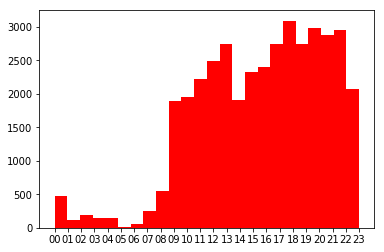

In [13]:
plt.hist(a,bins=24,color='red')
plt.show()

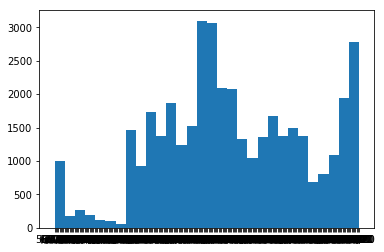

In [14]:
b=list(df.Date)
plt.hist(b,bins=30)
plt.show()

In [15]:
df.Author.value_counts()

villegas             14375
el enzo              10380
Sebastian Linares     8905
jose mierda           5511
mierdeo                 45
favrisio                43
Name: Author, dtype: int64

In [16]:
multimedia=df[df.Message=='<Media omitted>']

In [17]:
multimedia.Author.value_counts()

el enzo              1927
villegas             1218
Sebastian Linares    1035
jose mierda           423
favrisio               12
mierdeo                 7
Name: Author, dtype: int64

In [133]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)

In [134]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [11]:
messages_df.head()

,Date,Time,Author,Message,Days,Months,Years,Minutes,Hours,emoji,urlcount,Letter_Count,Word_Count
0,5/31/19,16:39,villegas,Gaaa,31,5,19,39,16,[],0,4,1
1,5/31/19,16:39,villegas,Mete a gozu,31,5,19,39,16,[],0,11,3
2,5/31/19,16:52,el enzo,Él es profesional,31,5,19,52,16,[],0,17,3
3,5/31/19,16:55,el enzo,"Bueno, ahora que sabemos que Mario fallará procd",31,5,19,55,16,[],0,48,8
4,5/31/19,16:56,Sebastian Linares,xddd,31,5,19,56,16,[],0,4,1


In [26]:
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of villegas -
Messages Sent 13157
Words per message 4.347115603861063
Media Messages Sent 1218
Emojis Sent 319
Links Sent 73

Stats of el enzo -
Messages Sent 8453
Words per message 4.479001537915533
Media Messages Sent 1927
Emojis Sent 412
Links Sent 23

Stats of Sebastian Linares -
Messages Sent 7870
Words per message 4.071791613722999
Media Messages Sent 1035
Emojis Sent 389
Links Sent 94

Stats of None -
Messages Sent 0
Words per message nan
Media Messages Sent 0
Emojis Sent 0
Links Sent 0

Stats of mierdeo -
Messages Sent 38
Words per message 3.736842105263158
Media Messages Sent 7
Emojis Sent 0
Links Sent 0

Stats of favrisio -
Messages Sent 31
Words per message 2.3548387096774195
Media Messages Sent 12
Emojis Sent 0
Links Sent 0

Stats of jose mierda -
Messages Sent 5088
Words per message 4.508058176100629
Media Messages Sent 423
Emojis Sent 65
Links Sent 22



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  # This is added back by InteractiveShellApp.init_path()


In [27]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

79


In [28]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😔,308
1,👌,239
2,😳,215
3,🤠,97
4,😭,45
...,...,...
74,💯,1
75,🥒,1
76,😩,1
77,💦,1


In [36]:
def lowercase(t):
    return t.lower()

In [37]:
def stopword_a():
    from nltk.corpus import stopwords
    stop_words_sp = set(stopwords.words('spanish'))
    stopwords = set(STOPWORDS)
    stopwords.update(list(stop_words_sp))
    stopwords.update(["ps","q","xd","si"])
    return stopwords

In [38]:
def get_words(series):
    series=series.apply(lowercase)
    text = " ".join(message for message in series)
    return text

In [39]:
def show_wordcloud(text):
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords_dict, background_color="white").generate(text)
    # Display the generated image:
    # the matplotlib way:

    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [40]:
def frequency_words(text):
    text_list=text.split(' ')
    text_list=[word for word in text_list if word not in stopwords_dict]
    words_dict = dict(Counter(text_list))
    words_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)
    words_df = pd.DataFrame(words_dict, columns=['word', 'count'])
    words_df.set_index('word').head(15).plot.barh()
    plt.show()

In [45]:
def get_word_statistics(series):
    global stopwords_dict
    stopwords_dict=stopword_a()
    text=get_words(series)
    show_wordcloud(text)
    frequency_words(text)

villegas


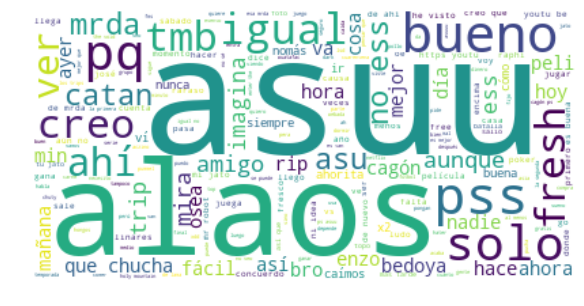

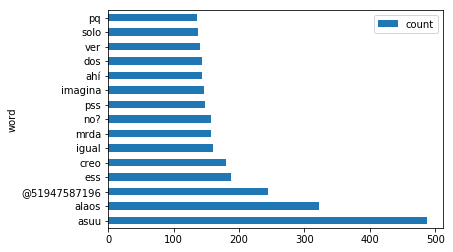

-----------------------------------------------
el enzo


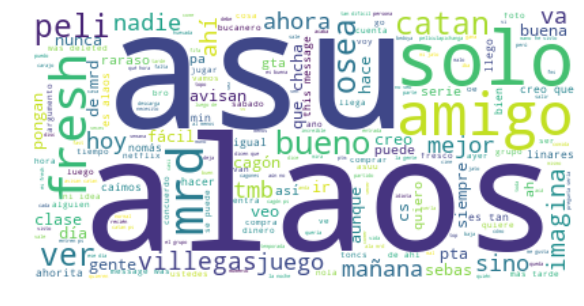

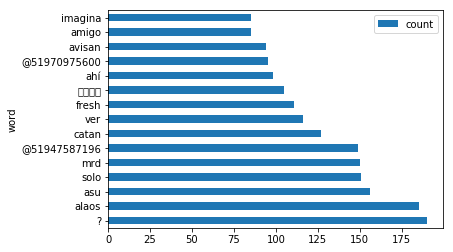

-----------------------------------------------
Sebastian Linares


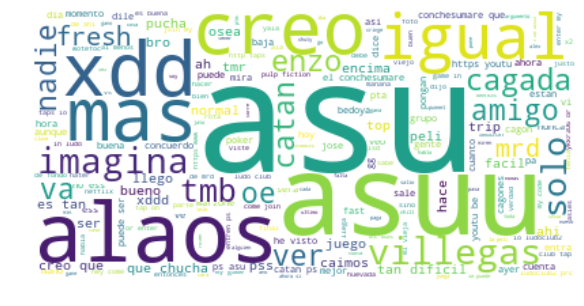

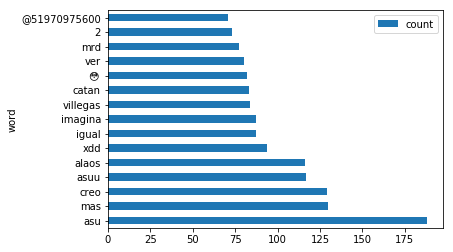

-----------------------------------------------
mierdeo


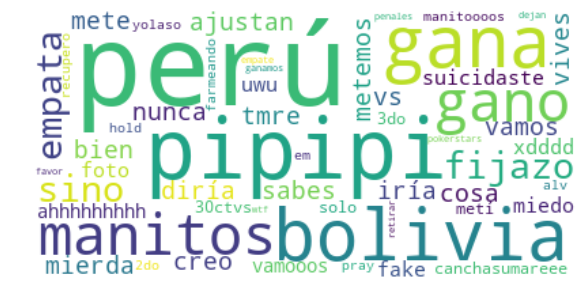

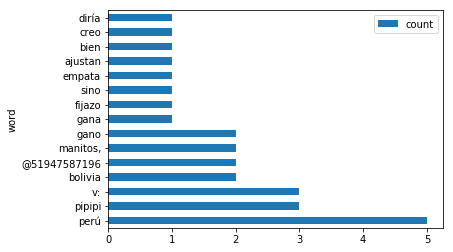

-----------------------------------------------
favrisio


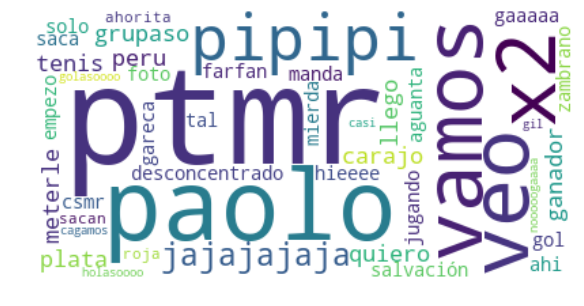

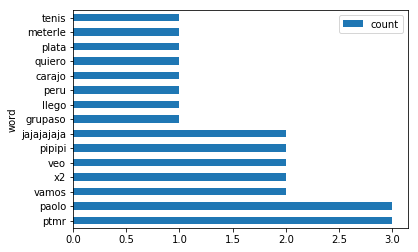

-----------------------------------------------
jose mierda


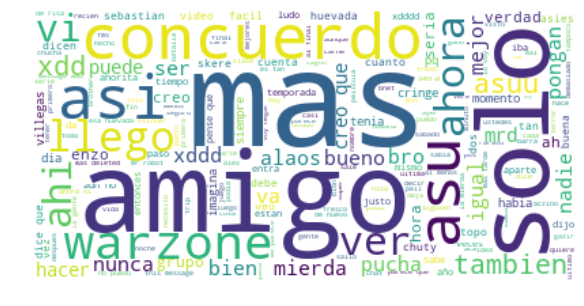

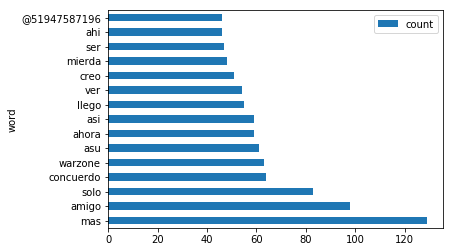

-----------------------------------------------


In [84]:
author_list=[author for author in messages_df.Author.unique() if author != None]
for author in author_list:
    author_dataframe=messages_df[messages_df.Author==author]
    print(author)
    get_word_statistics(author_dataframe.Message)
    print("-----------------------------------------------")

In [15]:
messages_df.Message=messages_df.Message.apply(lowercase)

In [178]:
messages_df[messages_df.Message.str.find(' mas ')>-1]

,Date,Time,Author,Message,Days,Months,Years,Minutes,Hours,emoji,urlcount,Letter_Count,Word_Count
264,6/13/19,14:25,Sebastian Linares,uno mas de mallorca,13,6,19,25,14,[],0,19,4
502,6/14/19,17:23,Sebastian Linares,roten mas fijas,14,6,19,23,17,[],0,15,3
1680,12/13/19,17:39,Sebastian Linares,estoy mas cheto,13,12,19,39,17,[],0,15,3
1752,12/20/19,11:50,Sebastian Linares,alguien mas careta que enzo?,20,12,19,50,11,[],0,28,5
2382,2/3/20,12:59,jose mierda,Nunca mas esa wea,3,2,20,59,12,[],0,17,4
2431,2/3/20,17:19,jose mierda,Esto es mas probable xd,3,2,20,19,17,[],0,23,5
2694,2/3/20,20:52,jose mierda,Cada vez los enzo ocurren mas prematuramente,3,2,20,52,20,[],0,44,7
2701,2/3/20,21:48,jose mierda,Es mas chill,3,2,20,48,21,[],0,12,3
3002,2/4/20,19:53,Sebastian Linares,aunque esos cogen mas lenguajes,4,2,20,53,19,[],0,31,5
3009,2/4/20,20:14,jose mierda,Anaconda suele ser mas comodo para data science,4,2,20,14,20,[],0,47,8


In [20]:
messages_df.Message.str.find('aburre')

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
39318   -1
39319   -1
39320   -1
39321   -1
39322   -1
Name: Message, Length: 34701, dtype: int64

In [19]:
'jaja aburre alaos'.rfind('aburre')

5

In [30]:
pd.set_option('display.max_rows', None)

In [135]:
def get_unique_words(counts, df_raw, version):
    """ Get a list of unique words 
    
    The dataframe needs be structured as follows:
    First column is called "Word" and contains a certain word
    Any following columns are named as the users and contain the
    count of each word. 
    
    |   |    Word   | Tim | Nadia | 
    | 1 | pride     | 0   | 1     |
    | 2 | groceries | 2   | 9     |
    etc. 
    
    Formulas:
    t_user = Number of times word t said by user
    t_all = Number of times word t said by all users
    sum_messages = Number of all messages
    messages_user = Number of messages user has send
    sum_words = Number of all words
    words_user = Number of words user has send
    
    Version A
    TF_IDF = ((t_user+1)^2 / t_all) * (sum_messages / messages_user)
    Version B
    TF_IDF = ((t_user+1)^2 / t_all) * (sum_words / words_user)
    Version C
    TF_IDF = (t_user + 1) / (words_user + 1) * log(sum_messages / t_all)
    
    Parameters:
    -----------
    counts : pandas dataframe
        Dataframe of counts per word per user
    df_raw : pandas dataframe
        Dataframe of raw messages
    version : string
        Which formula to use (A, B, C)
    Returns:
    --------
    df_words : pandas dataframe
        Dataframe tf_idf scores per word per user and unique value
    
    """
    
    df_words = counts.copy()
    
    # Number of messages by i 
    nr_messages = {user: len(df_raw[df_raw.Author == user]) for user in df_words.columns[1:]}
    nr_users = len(nr_messages.keys())
    nr_words = {user: np.sum(df_words[user]) for user in df_words.columns[1:]}
    total = sum(nr_messages.values())

    # Calculate TF_IDF based on the version
    for user in nr_messages.keys():
        df_words[user+"_TF_IDF"] = df_words.apply(lambda row: tf_idf(row, user, 
                                                                    nr_users, nr_words,
                                                                    nr_messages, version=version), 
                                              axis = 1)

    # TF_IDF divided by each other so we can see the relative importance
    for user in nr_messages.keys():
        df_words[user+"_Unique"] = df_words.apply(lambda row: word_uniqueness(row, 
                                                                             nr_users,
                                                                             user),
                                                  axis = 1)
        
    return df_words

def tf_idf(row, user, nr_users, nr_words, nr_messages, version):
    """ Used as a lambda function inside get_unique_words() to 
        get the tf_idf scores based on one of three formulas
    
    Formulas:
    t_user = Number of times word t said by user
    t_all = Number of times word t said by all users
    sum_messages = Number of all messages
    messages_user = Number of messages user has send
    sum_words = Number of all words
    words_user = Number of words user has send
    
    Version A
    TF_IDF = ((t_user+1)^2 / t_all) * (sum_messages / messages_user)
    Version B
    TF_IDF = ((t_user+1)^2 / t_all) * (sum_words / words_user)
    Version C
    TF_IDF = (t_user + 1) / (words_user + 1) * log(sum_messages / t_all)
    
    """
    
    # TF_IDF = (t_user^2 / t_all) * (sum of messages / messages by user)
    if version == "A":
        t_user = row[user]
        t_all =  np.sum(row.iloc[1:nr_users+1])
        sum_messages = sum(nr_messages.values())
        messages_user = nr_messages[user]
        
        tf_idf = (np.square(t_user + 1) / (t_all)) * (sum_messages / messages_user)
        
        return tf_idf
    
    # TF_IDF = (t_user^2 / t_all) * (sum of words / words by user)
    elif version == "B":
        t_user = row[user]
        t_all =  np.sum(row.iloc[1:nr_users+1])
        sum_words = sum(nr_words.values())
        words_user = nr_words[user]
        
        tf_idf = (np.square(t_user + 1) / (t_all)) * (sum_words / words_user)
        
        return tf_idf
    
    # TF_IDF = (t_user / words_user) * log(sum of messages / t_all)
    elif version == "C":
        t_user = row[user]
        words_user = nr_words[user]

        sum_messages = sum(nr_messages.values())
        t_all =  np.sum(row.iloc[1:nr_users+1])
        
        tf_idf = (t_user + 1 / words_user + 1) * np.log(sum_messages / t_all)
        
        return tf_idf
    
def word_uniqueness(row, nr_users, user):
    """ Used as a lambda function in function get_unique_words()
    
    Formula:
    
    word_uniqueness = tf_idf_user / (tf_idf_all - tf_idf_user)
    
    """
    
    tf_idf_user = row[user+"_TF_IDF"]
    tf_idf_all = np.sum(row.iloc[nr_users+1: 2*nr_users+1])
    
    with np.errstate(divide='ignore'):
        unique_value_user = np.divide(tf_idf_user, 
                                      (tf_idf_all - tf_idf_user))
    
    return unique_value_user

In [170]:
palabras_autor=messages_df[messages_df.Author=='jose mierda'].Message

In [171]:
text=get_words(palabras_autor)

In [172]:
text_list=text.split(' ')
text_list=[word for word in text_list if word not in stopwords_dict]
words_dict = dict(Counter(text_list))
words_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)
jose = pd.DataFrame(words_dict, columns=['word', 'count'])

In [139]:
words_df_1

,word,count
0,que,927
1,no,720
2,de,679
3,es,550
4,la,496
5,a,460
6,en,401
7,el,375
8,si,305
9,y,291


In [71]:
union=pd.merge(words_df_1,words_df_2,how='outer',on='word').fillna(0)

In [81]:
union=pd.merge(union,words_df_1,how='outer',on='word').fillna(0)

In [82]:
union.head()

,word,count_x,count_y,count_x,count_y
0,no,1692.0,1256.0,1008.0,720.0
1,de,1652.0,971.0,881.0,679.0
2,que,1644.0,1216.0,1037.0,927.0
3,es,1584.0,925.0,801.0,550.0
4,la,1088.0,718.0,617.0,496.0


In [84]:
union.columns=['word', 'villegas', 'el enzo', 'Sebastian Linares', 'jose mierda']

In [89]:
unique=get_unique_words(union,messages_df,'C')

In [90]:
unique.head()

,word,villegas,el enzo,Sebastian Linares,jose mierda,villegas_TF_IDF,el enzo_TF_IDF,Sebastian Linares_TF_IDF,jose mierda_TF_IDF,villegas_Unique,el enzo_Unique,Sebastian Linares_Unique,jose mierda_Unique
0,no,1692.0,1256.0,1008.0,720.0,3386.821741,2514.610144,2018.489786,1442.350028,0.566789,0.367222,0.274857,0.182117
1,de,1652.0,971.0,881.0,679.0,3490.970251,2052.766570,1862.695607,1436.091892,0.652328,0.302333,0.266868,0.193898
2,que,1644.0,1216.0,1037.0,927.0,3239.539559,2396.668503,2044.159348,1827.533629,0.516808,0.337026,0.273879,0.237949
3,es,1584.0,925.0,801.0,550.0,3474.734064,2030.033943,1758.193563,1207.936025,0.695480,0.315180,0.261920,0.166315
4,la,1088.0,718.0,617.0,496.0,2691.667520,1777.143239,1527.502833,1228.428699,0.593784,0.326225,0.268113,0.204864


In [106]:
unique.sort_values(['villegas_Unique'],ascending=False).head(10)

,word,villegas,el enzo,Sebastian Linares,jose mierda,villegas_TF_IDF,el enzo_TF_IDF,Sebastian Linares_TF_IDF,jose mierda_TF_IDF,villegas_Unique,el enzo_Unique,Sebastian Linares_Unique,jose mierda_Unique
42,mrda,157.0,0.0,0.0,0.0,852.321278,5.394580,5.394606,5.394673,52.664896,0.006250,0.006250,0.006250
162,ví,43.0,0.0,0.0,0.0,294.337394,6.689660,6.689692,6.689775,14.666178,0.021740,0.021740,0.021740
110,rip,63.0,2.0,1.0,0.0,400.705961,18.783252,12.522253,6.261302,10.666490,0.044776,0.029412,0.014493
202,josé,36.0,1.0,0.0,0.0,253.071453,13.679712,6.839979,6.840064,9.249770,0.051283,0.025001,0.025001
323,wuatafac,22.0,0.0,0.0,0.0,169.271877,7.359836,7.359871,7.359962,7.666414,0.040001,0.040001,0.040002
353,sebitas,20.0,0.0,0.0,0.0,156.554110,7.455148,7.455184,7.455276,6.999770,0.043479,0.043479,0.043480
56,pq,136.0,0.0,0.0,20.0,739.913485,5.400970,5.400996,113.417617,5.956496,0.006289,0.006290,0.151079
65,??,120.0,7.0,11.0,0.0,668.335126,44.187586,66.281332,5.523671,5.761878,0.059702,0.092308,0.007093
337,tres,21.0,0.0,1.0,0.0,161.912236,7.359836,14.719512,7.359962,5.499865,0.040001,0.083334,0.040002
475,género,15.0,0.0,0.0,0.0,123.882271,7.742838,7.742875,7.742971,5.333159,0.055557,0.055557,0.055558


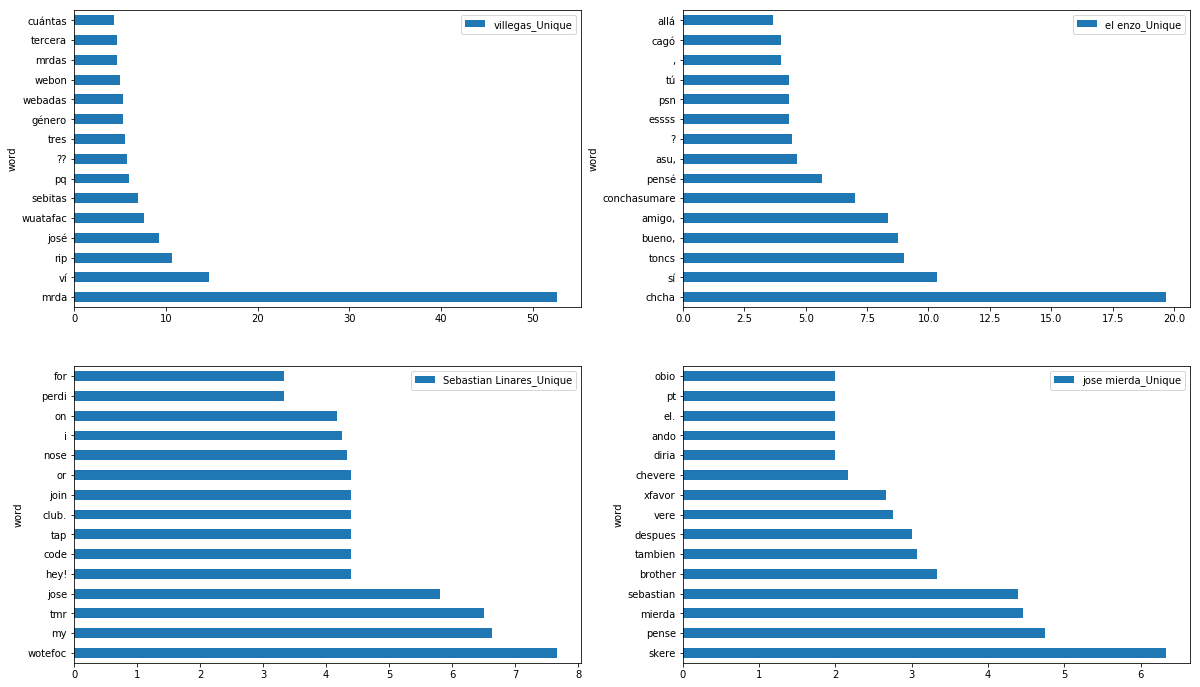

In [124]:
figure, axes=plt.subplots(2,2,figsize=(20,12))
unique.sort_values(['villegas_Unique'],ascending=False).set_index('word').head(15).plot.barh(y='villegas_Unique' ,ax=axes[0,0])
unique.sort_values(['el enzo_Unique'],ascending=False).set_index('word').head(15).plot.barh(y='el enzo_Unique', ax=axes[0,1])
unique.sort_values(['Sebastian Linares_Unique'],ascending=False).set_index('word').head(15).plot.barh(y='Sebastian Linares_Unique', ax=axes[1,0])
unique.sort_values(['jose mierda_Unique'],ascending=False).set_index('word').head(15).plot.barh(y='jose mierda_Unique', ax=axes[1,1])
plt.show()

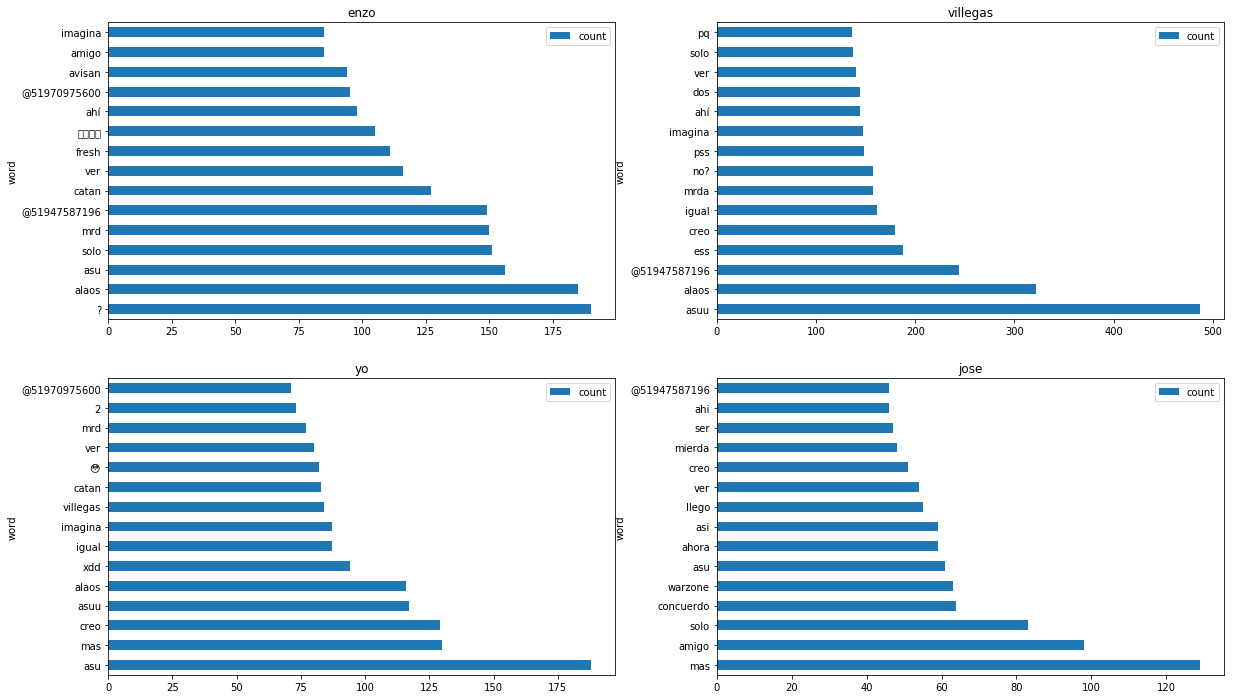

In [175]:
figure, axes=plt.subplots(2,2,figsize=(20,12))
enzo.head(15).plot.barh(x='word',y='count',ax=axes[0,0],title='enzo')
villegas.head(15).plot.barh(x='word',y='count',ax=axes[0,1],title='villegas')
yo.head(15).plot.barh(x='word',y='count',ax=axes[1,0],title='yo')
jose.head(15).plot.barh(x='word',y='count',ax=axes[1,1],title='jose')
plt.show()

In [155]:
word_df_4.head(15).plot.barh()

NameError: name 'word_df_4' is not defined